Sentinel+TRUTHS
(41, 11)
test


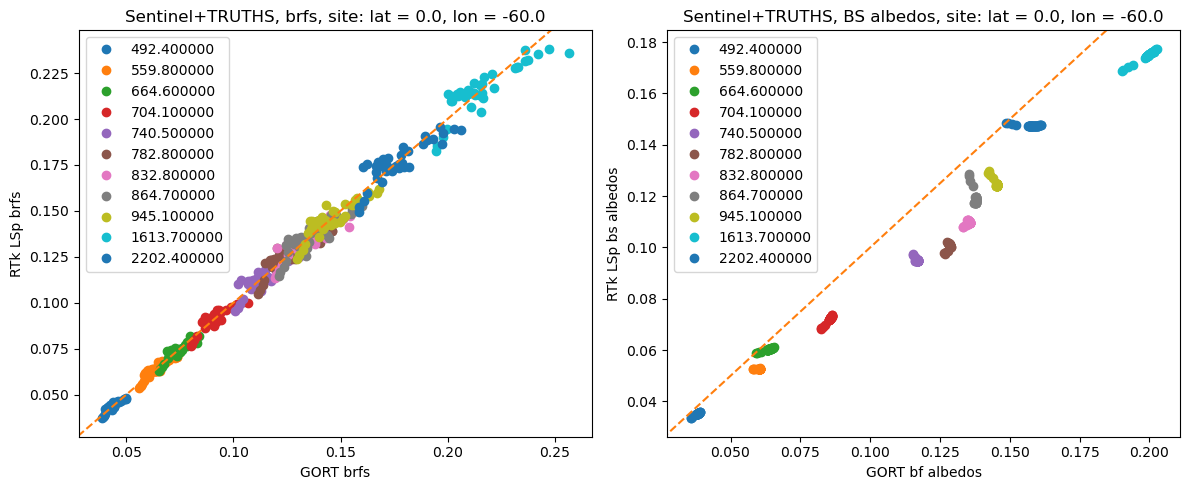

In [30]:
import numpy as np
from copy import copy

import importlib
import brdfFile
import gort
import kernels
importlib.reload(brdfFile)
importlib.reload(gort)
importlib.reload(kernels)
from brdfFile import brdfFile
from gort import gort, geom
from kernels import kernelBRDF
import pandas as pd

from matplotlib import pyplot as plt 

def geom_list_from_brdfFile(b):
    geom_list = []
    for i in range(b.nAngles):
        geom_list.append(geom(vza=b.vza_arr[i], vaa=b.vaa_arr[i], sza=b.sza_arr[i], saa=b.saa_arr[i]))
    return geom_list

def add_obs_brfs_to_kernelBRDF(brfs,k):
    """note - it is entirely on the user to make sure the 
    number of samples in the brfs matches the wavelengths
    and angles in the brdfFile object
    """

    for i in range( k.nAngles ):
        for j in range( k.nWavelengths ):
            k.brfObs[i][j]=brfs[i][j]

    return k

latitude=0.0#40.0
longitude=-60.0#0.0
add_noise=True
eps = 1e-3# Avoid σ=0 when reflectance is 0
rel_err_Sentinel=0.03
rel_err_TRUTHS=0.003
rel_err_TEST=0.0
rng = np.random.default_rng(42)

experiment = 'Sentinel+TRUTHS' # 'TRUTHS','Sentinel', 'Sentinel+TRUTHS' or 'test'
if experiment == 'Sentinel':
    filename='/home/users/ndouglas/TRUTHS/Geometries/Sentinel/SentinelGeometries/SentinelGeomsLAT'+str(latitude)+'LON'+str(longitude)+'.brdf'
elif experiment == 'TRUTHS':
    filename='/home/users/ndouglas/TRUTHS/Geometries/TRUTHS/TRUTHSgeometries/TRUTHSgeomsLAT'+str(latitude)+'LON'+str(longitude)+'.brdf'
elif experiment == 'Sentinel+TRUTHS':
    filename='/home/users/ndouglas/TRUTHS/Geometries/Sentinel+TRUTHS/Sentinel+TRUTHSGeometries/Sentinel+TRUTHSGeomsLAT'+str(latitude)+'LON'+str(longitude)+'.brdf'
else:
    filename="./HEMItest.brdf"

k=kernelBRDF( )
k.readBRDF(filename)
geom_list=geom_list_from_brdfFile(k)

g=gort() 
g.params["LAI"]=1.0
g.params["PCC"]=0.3
g.params["HB"]=1.1
g.params["BR"]=1.0
g.wavl=copy(k.wavelengths)  
brfs_temp, comp, enrg = g.run(geom_list, verbose=False)

if add_noise:
    print(experiment)
    if experiment == "Sentinel":
        sigma_arr = rel_err_Sentinel * np.maximum(brfs_temp, eps)
    elif experiment == "TRUTHS":
        sigma_arr = rel_err_TRUTHS * np.maximum(brfs_temp, eps)
    elif experiment == "Sentinel+TRUTHS":
        sigma_arr = np.zeros_like(brfs_temp, dtype=float)
        print(np.shape(sigma_arr))
        print('test')
        sigma_arr[:33] = rel_err_Sentinel * np.maximum(brfs_temp[:33], eps)
        sigma_arr[33:] = rel_err_TRUTHS * np.maximum(brfs_temp[33:], eps)
    else:
        print('probably here')
        sigma_arr = rel_err_TEST * np.maximum(brfs_temp, eps)
    noise = rng.normal(0.0, sigma_arr)
    #print(brfs_temp,noise)
    brfs = brfs_temp + noise      
else:    
    brfs=brfs_temp.copy()
    
k=add_obs_brfs_to_kernelBRDF(brfs,k)

weights=k.solveKernelBRDF()
k.predict_brfs(weights)
#print(k.brf,k.brfObs)
kbs=[]
for i in range(len(k.sza_arr)):
    kbs.append(k.predictBSAlbedoRTkLSp(weights,k.sza_arr[i]))
#print('kbs',kbs,np.shape(kbs))

gort_alb=enrg[:,::3]
#print('gort_alb',gort_alb,np.shape(gort_alb))

fig,(ax1,ax)=plt.subplots(1, 2,figsize=(12,5))


for j in range( k.nWavelengths ):
    ax1.plot(np.transpose(k.brfObs)[j],np.transpose(k.brf)[j],"o",label="%f"%np.round(k.wavelengths[j],1))
ax1.set_title(str(experiment)+', brfs, site: lat = '+str(latitude)+', lon = '+str(longitude))
#draw a 1:1 line
#ax1=plt.gca()
xlims1=ax1.get_xlim()
ylims1=ax1.get_ylim()
ax1.plot([0,1],[0,1],"--")
ax1.set_xlim(xlims1)
ax1.set_ylim(ylims1)
    
ax1.set_ylabel("RTk LSp brfs")
ax1.set_xlabel("GORT brfs")
ax1.legend()


for j in range( k.nWavelengths ):
    ax.plot(np.transpose(gort_alb)[j],np.transpose(kbs)[j],"o",label="%f"%np.round(k.wavelengths[j],1))
ax.set_title(str(experiment)+', BS albedos, site: lat = '+str(latitude)+', lon = '+str(longitude))
#draw a 1:1 line
#ax=plt.gca()
xlims=ax.get_xlim()
ylims=ax.get_ylim()
ax.plot([0,1],[0,1],"--")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
    
ax.set_ylabel("RTk LSp bs albedos")
ax.set_xlabel("GORT bf albedos")
ax.legend()

#plt.show()
fig.tight_layout()